Time Series : Netflix Subscriptions Forecasting

In [43]:
# Importing Necessay Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [45]:
# reading the data
data = pd.read_csv('Netflix Subscriptions Forecast.csv')
print(data.head())

  Time Period  Subscribers
0  01/04/2013     34240000
1  01/07/2013     35640000
2  01/10/2013     38010000
3  01/01/2014     41430000
4  01/04/2014     46130000


In [47]:
# lets convert time period column into datatime format.
data['Time Period'] = pd.to_datetime(data['Time Period'],
                                    format='%d/%m/%Y')
print(data.head())

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


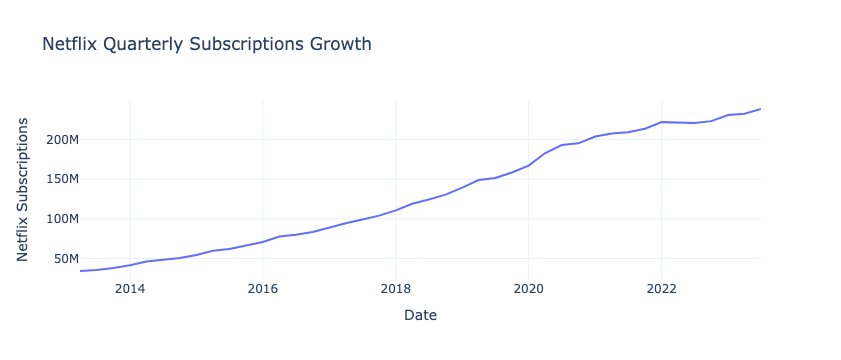

In [49]:
# Now let’s have a look at the quarterly subscription growth of Netflix:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Time Period'],
                        y=data['Subscribers'],
                        mode='lines', name='Subsribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                 xaxis_title='Date',
                 yaxis_title='Netflix Subscriptions')
fig.show()

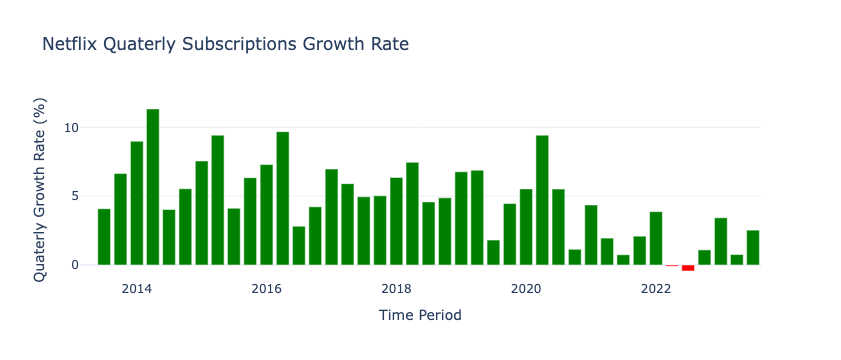

In [51]:
# Calculate the quarterly growth rate
data['Quarterly Growth Rate'] = data['Subscribers'].pct_change() * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Time Period'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quaterly Subscriptions Growth Rate',
                 xaxis_title='Time Period',
                 yaxis_title='Quaterly Growth Rate (%)')
fig.show()

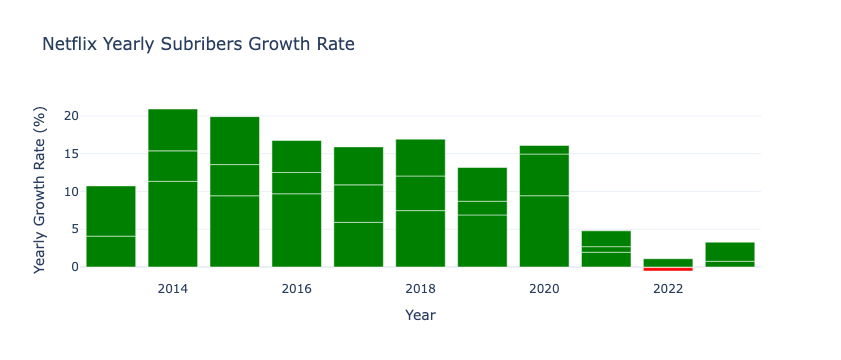

In [53]:
# Calculate the yearly growth rate
data['Year'] = data['Time Period'].dt.year
yearly_growth = data.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subribers Growth Rate',
                 xaxis_title='Year',
                 yaxis_title='Yearly Growth Rate (%)')
fig.show()

Using ARIMA for Forecasting Netflix Quarterly Subscriptions

In [56]:
# converting the data into a time series format
time_series = data.set_index('Time Period')['Subscribers']

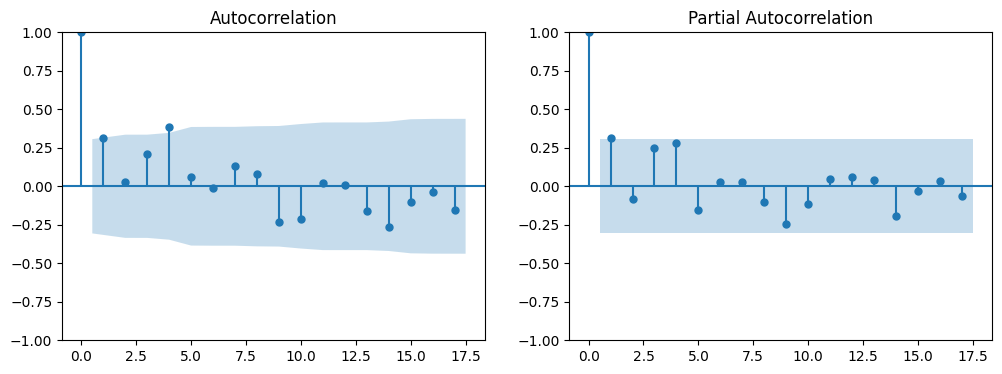

In [58]:
# let’s find the value of p and q by plotting the ACF and PACF of differenced time series
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [60]:
# how to use the ARIMA model on our data
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Sat, 21 Jun 2025   AIC                           1351.986
Time:                        12:43:04   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.776      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



In [62]:
#  how to make predictions using the trained model-
# -to forecast the number of subscribers for the next five quarters

future_steps = 5
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-10-01    243321481
2024-01-01    248251694
2024-04-01    253180640
2024-07-01    258108318
2024-10-01    263034730
Freq: QS-OCT, Name: predicted_mean, dtype: int64


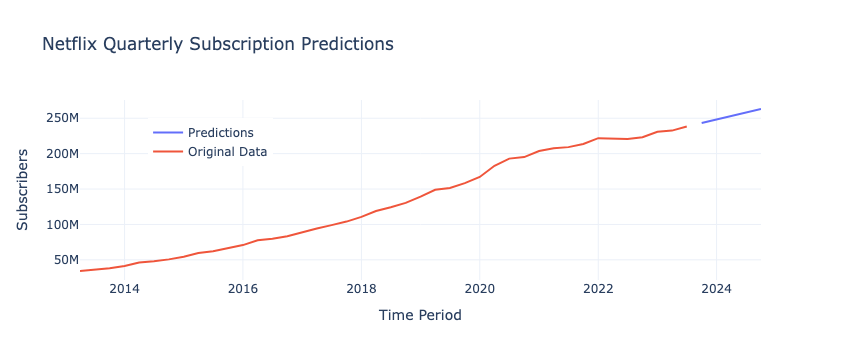

In [64]:
# let’s visualize the results of Netflix Subscriptions Forecasting for the next five quarters
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({"Original" : time_series, "Predictions" : predictions})
# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()